In [5]:
from pathlib import Path
from matplotlib import pyplot as plt
import pysam 
import numpy as np
from Bio import SeqIO
import time 
import matplotlib.patches as patches
import matplotlib.cm as cm
import itertools
from tabulate import tabulate
import csv
import random

np.set_printoptions(threshold=np.inf)
min_quality_score = 8



assembly_ = open("/private/groups/migalab/dan/reference/hg002v1.0.1.fasta", "r")

start_time = time.time()

#Load the reference genome and make it into a dictionary 
fasta_sequences = SeqIO.parse(assembly_, "fasta")
assembly={}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    assembly[name] = sequence

#Make a dictionary for all the chromosomes and their corresponding sequence length 
assembly_sequence_length = {}    
for chromosome in assembly:
    assembly_sequence_length[chromosome] = len(assembly[chromosome])
    
end_time = time.time()
elapsed_time = end_time - start_time
print (elapsed_time, "seconds")
assembly_.close()



67.87225317955017 seconds


In [6]:
CDR_regions = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
output_dir = Path('/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region')
CENPA_AS_bam_file = '/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD.bam'
CENPC_AS_bam_file = '/private/groups/migalab/dan/01_09_24_R1041_DiMeLoAdaptive_CENPC/01_09_24_R1041_DiMeLoAdaptive_CENPC/01_09_24_R1041_DiMeLoAdaptive_CENPC/20240109_1200_6B_PAS52674_0adbae11/pod5_pass/explicit/01_09_24_R1041_DiMeLoAdaptive_CENPC_5mC_6mA_winnowmap_sorted_modkit.bam'
H3K9me3_AS_bam_file = '/private/groups/migalab/dan/08_05_24_R1041_ULadapt_Dimelo_H3K9ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_1/20240805_1148_1F_PAU87705_0451cc00/pod5/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_mA_mC_winnowmap_sorted_MD.bam'
ref_genome_file = Path('/private/groups/migalab/dan/reference/hg002v1.0.1.fasta')


In [7]:
CENPA_bamfile = pysam.AlignmentFile(CENPA_AS_bam_file, "rb")
CENPC_bamfile = pysam.AlignmentFile(CENPC_AS_bam_file, "rb")
H3K9me3_bamfile = pysam.AlignmentFile(H3K9me3_AS_bam_file, "rb")


In [1]:
def plot_data_and_derivatives(x, y, dy, title):
    plt.plot(x, y, '-o', label='Data')
    for xi, yi, dyi in zip(x, y, dy):
        # Scale factor for visualizing derivatives
        scale = 0.5
        # Calculate the end points of the derivative line
        dx = scale
        dy = dyi * scale
        plt.plot([xi, xi + dx], [yi, yi + dy], 'r-')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)

In [2]:
'''
The idea of this function is to isolate the the desired regions (here in the function, it is called the subset) in the mod 
numpy array without dashes(insertions)'''

def mod_subset_producing_step (mod_no_dash,alignment_dash,target_start_no_dash,target_end_no_dash):
    #mod_no_dash = is the numpy array of the mod without any insertions and deletions
    # alignment_dash = is the alignment sequence with the dashes in it 
    # target_start = it's the subset starting position WITHOUT the dashes!!! 


    # Create a mask to identify non-dash positions
    mask = [char != '_' for char in alignment_dash]

    # Generate cumulative counts only for True values in the mask
    cumulative_counts = list(itertools.accumulate(mask))

    # Create the final indexes list
    indexes = [count - 1 if is_non_dash else '-' for count, is_non_dash in zip(cumulative_counts, mask)]
    target_start_dash = indexes.index (target_start_no_dash)
    target_end_dash = indexes.index (target_end_no_dash)

    #obtain dashed alignment 
    alignment_dash_sequence_pre_subset = alignment_dash[0:target_start_dash]
    alignment_dash_sequence_subset = alignment_dash[target_start_dash:target_end_dash]

    #create no dash alignment 
    alignment_no_dash_sequence_pre_subset = alignment_dash_sequence_pre_subset.replace("-","")
    alignment_no_dash_sequence_subset = alignment_dash_sequence_subset.replace("-","")

    subset_no_dash_start = len(alignment_no_dash_sequence_pre_subset)
    subset_no_dash_end = subset_no_dash_start + len(alignment_no_dash_sequence_subset)

    #make mod_no_dash alignment
    mod_subset = mod_no_dash[subset_no_dash_start:subset_no_dash_end]

    return mod_subset

In [3]:
''' 

The input of the function is a dictionary in the format of 'chromosome':[[start,end],[start,end]] 
'''
from sklearn.linear_model import LinearRegression

def single_mod_density_calculator(bamfile, transition_coordinate, mod_tag,interval_num): 
    strand_status = "forward"
    transition_parse = transition_coordinate.split (":")
    chr_name = transition_parse[0]
    region_start_index = int(transition_parse[1].split("-")[0])
    region_end_index = int(transition_parse[1].split("-")[1])
    read_first_derivatives = [] 
    read_second_derivatives = [] 
    read_density_values = []
    read_id_list = [] 
    forward_reverse_status = [] 

    tested_region_length = region_end_index - region_start_index

    for read in bamfile.fetch(chr_name,region_start_index,region_end_index):
        
        
        single_molecule_density_values = []
        #make an if statement to check a specific read front, middle, end regions 
        #setting read start, end, density, length variables 
            
        #Get the starting and ending positions of the reads 
        read_start_position = read.reference_start
        read_end_position = read.reference_end

        #Get sequence information which shows deletions and insertions 
        sequence = read.get_aligned_pairs(matches_only=False, with_seq = True)

        #make |a numpy of the sequence length which eliminates the deletion
        sequence_insertions = []
        sequence_deletions = [] 
        
        aligned_sequence = ''
        original_sequence = ''


        for item in sequence:
            #this is where the deletion is 
            if item[0] is None:
                sequence_deletions.append (item[1] - read_start_position)
                aligned_sequence+='-'
            #this is where the insertion is 
            elif item[1] is None:
                sequence_insertions.append (item[0])
                original_sequence += '-'
                
            else: 
                aligned_sequence+=item[2]
                original_sequence +=item[2]
        
        #We are keeping the sequence with deletion because the total avaliable positions are affected 
        aligned_sequence = aligned_sequence.upper()
        original_sequence = original_sequence.upper()

        mod_score = np.zeros(len(original_sequence),)

        original_sequence_mask = np.array([char != '-' for char in original_sequence])

        
        #make a mod np array with the length of the read length
        mod=read.modified_bases_forward
        

        # if the reads are longer than the region selected 
        if (tested_region_length) <= (read_end_position - read_start_position):
            # scenario 1: when the defined region is inside the read
            if (read_start_position <= region_start_index) and (read_end_position >= region_end_index):
                mod_start = region_start_index - read_start_position 
                mod_end = region_end_index - read_start_position

            else:
                continue
        else:
            continue 
        
        #Here, I am making the the densities of mods in different intervals as the y axis of a function
        #I have the interval position as the x axis 
        # then I will plot their linear regression models and use their slops 
        
        # calculating total distance 
        transition_length = mod_end - mod_start
        

        read_id = read.query_name

        #mod information sorting 
        if mod_tag == "A":
            try:
                for indices, values in mod[('A', 0, 'a')]:
                    mod_score[indices] = values
                mod_score = mod_score[original_sequence_mask]
                
                if read.is_reverse:
                    strand_status = "reverse"
                    forward_reverse_status.append(strand_status)
                    mod_score = mod_score[::-1]
                    
                else: 
                    forward_reverse_status.append(strand_status)
                

            except KeyError:
                continue
        elif mod_tag == "CG":

            try: 
                for indices, values in mod[('C', 0, 'm')]:
                    mod_score[indices] = values
                mod_score = mod_score[original_sequence_mask]
                
                if read.is_reverse:
                    strand_status = "reverse"
                    forward_reverse_status.append(strand_status)
                    mod_score = mod_score[::-1]
                    
                else: 
                    forward_reverse_status.append(strand_status)


            except KeyError:
                continue

        
        #defining how far the intervals are 
        interval = int((transition_length)/ interval_num)
        
        read_id_list.append(read_id)
        #calculating y (mods per interval)
        for interval_section in range (0,interval_num):
            #defining the interval section 
            interval_genomic_start = mod_start + interval * interval_section 
            interval_genomic_end = mod_start + interval * (interval_section + 1 )

            # counting mod possible positions and mods in each interval for density calculation 

            interval_genomic_mod_potentials = aligned_sequence[interval_genomic_start:interval_genomic_end ].count(mod_tag)

            interval_genomic_total_subset = mod_subset_producing_step (mod_score,aligned_sequence,interval_genomic_start,interval_genomic_end)

            total_mod_count = len(interval_genomic_total_subset[interval_genomic_total_subset!= 0])

            interval_genomic_mod_density = total_mod_count / interval_genomic_mod_potentials

            single_molecule_density_values.append (interval_genomic_mod_density)
            

        
        single_molecule_density_values = np.array(single_molecule_density_values)
        read_density_values.append (single_molecule_density_values)

        
        interval_sections = np.arange(interval_num)
        dy_read = np.gradient(single_molecule_density_values, interval_sections)
        dy2_read = np.gradient(dy_read, interval_sections)
        read_second_derivatives.append(dy2_read)
        read_first_derivatives.append (dy_read)

    return read_first_derivatives,read_second_derivatives,read_id_list, forward_reverse_status, read_density_values

In [22]:

target_region = "chr17_MATERNAL:25869048-25890025"
CENPA_read_derivatives_mA,CENPA_read_second_derivatives_mA,CENPA_read_id_list, CENPA_forward_reverse_status, CENPA_read_density_values_mA= single_mod_density_calculator(CENPA_bamfile,target_region, 'A',10)
CENPA_read_derivatives_mCG,CENPA_read_second_derivatives_mCG,CENPA_read_id_list, CENPA_forward_reverse_status, CENPA_read_density_values_mCG= single_mod_density_calculator(CENPA_bamfile,target_region, 'CG',10)

H3K9_read_derivatives_mCG,H3K9_read_second_derivatives_mCG,H3K9_read_id_list, H3K9_forward_reverse_status, H3K9_read_density_values_mCG= single_mod_density_calculator(H3K9me3_bamfile,target_region, 'CG',10)
H3K9_read_derivatives_mA,H3K9_read_second_derivatives_mA,H3K9_read_id_list_mA, H3K9_forward_reverse_status_mA, H3K9_read_density_values_mA= single_mod_density_calculator(H3K9me3_bamfile,target_region, 'A',10)

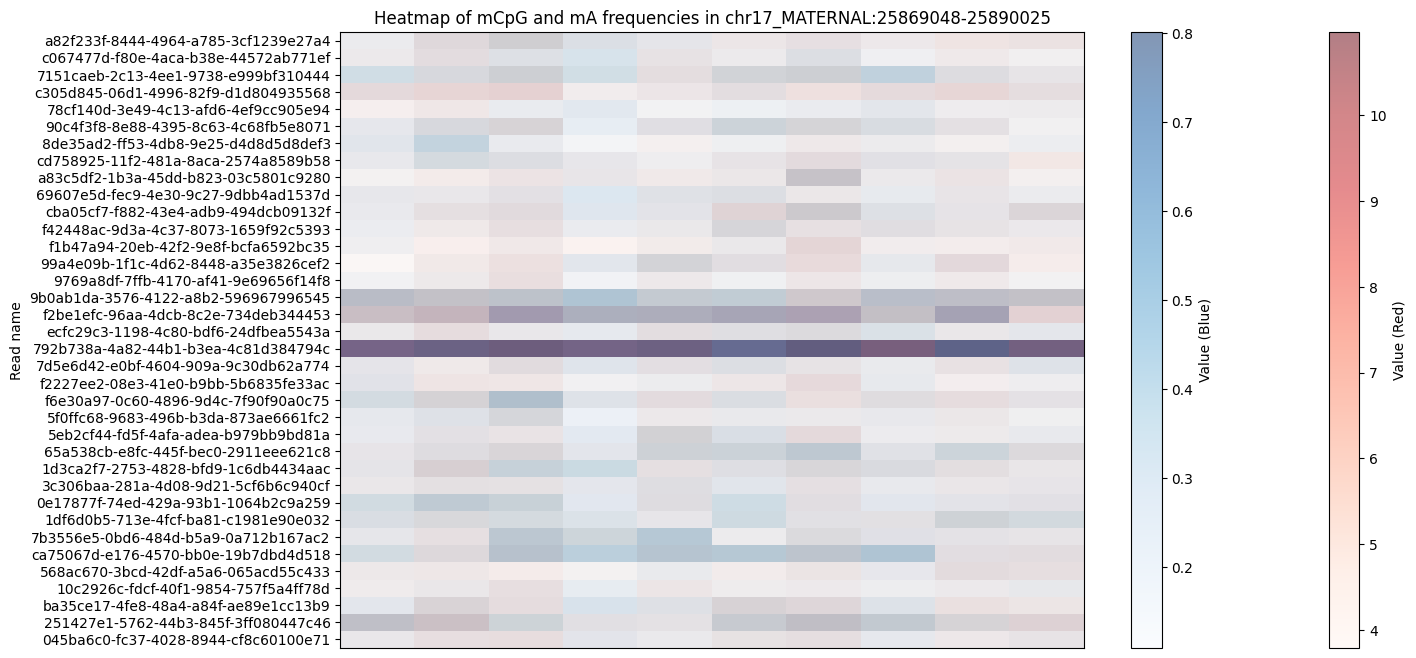

In [23]:

def plot_heatmap(data1, data2, y_labels, target_region):
    # Ensure data is a numpy array
    data1 = np.array(data1)
    data2 = np.array(data2)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Display the first heatmap with the 'Reds' colormap
    cax1 = ax.imshow(data1, aspect='auto', cmap='Reds', interpolation='nearest', alpha=0.5)
    
    # Display the second heatmap with the 'Blues' colormap
    cax2 = ax.imshow(data2, aspect='auto', cmap='Blues', interpolation='nearest', alpha=0.5)
    
    # Add colorbars
    cbar1 = fig.colorbar(cax1, ax=ax, orientation='vertical')
    cbar1.set_label('Value (Red)')
    
    cbar2 = fig.colorbar(cax2, ax=ax, orientation='vertical')
    cbar2.set_label('Value (Blue)')
    
    # Outline individual negative values for the first dataset
    for (i, j), val in np.ndenumerate(data1):
        if val < 0:
            rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=1, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
    
    # Outline individual negative values for the second dataset
    for (i, j), val in np.ndenumerate(data2):
        if val < 0:
            rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=1, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
    
    # Set labels
    ax.set_ylabel('Read name')
    ax.set_title('Heatmap of mCpG and mA frequencies in ' + target_region)
    
    # Set custom y-axis labels
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels)

    ax.set_xticks([])
    ax.set_xticklabels([])
    
    plt.show()




plot_heatmap(CENPA_read_density_values_mCG, CENPA_read_density_values_mA, CENPA_read_id_list, target_region)

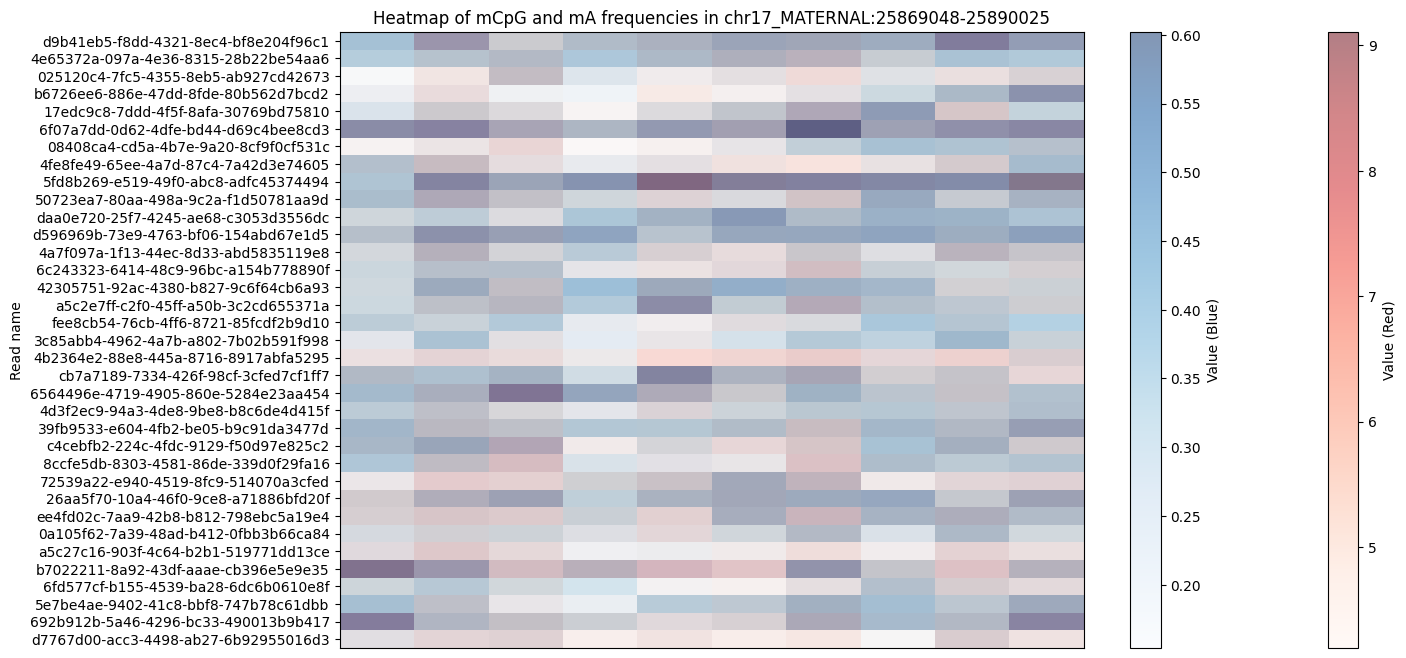

In [24]:
plot_heatmap(H3K9_read_density_values_mCG, H3K9_read_density_values_mA, H3K9_read_id_list, target_region)